In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt 
import os
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

In [ ]:
pip list

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[]

### Remove Dodgy Images

In [5]:
data_dir = 'data'

In [6]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
os.listdir(data_dir)

['happy', 'sad']

In [8]:
os.listdir(os.path.join(data_dir, 'happy'))

['05-12-21-happy-people.jpg',
 '1000_F_165246984_Ihe5LVattiq8zEPivcPqrtM85x7noWJw.jpg',
 '1000_F_42220133_toAU6USGY9jVr2XJFLssfG00cSYIJ173.jpg',
 '110754-utyeqqosky-1547658396.jpeg',
 '13ryLrJDyVF05wXDYYUXcJQ.jpeg',
 '170404-happy-workers-feature.jpg',
 '1HEoLBLidT2u4mhJ0oiDgig.png',
 '20150413185238-secrets-happy-entrepreneurs-woman-gratitude-rainbow-.jpeg',
 '343515-worldhappinessreport1440.jpg',
 '35438_hd.jpg',
 '360_F_484873483_hg1ofIdXbMha5lKEDG3hJBrwKh1oikTq.jpg',
 '56f455011e0000b300705475.jpeg',
 '613k1XcpYCL.jpg',
 '7-principles-of-successful-and-happy-people.png',
 '89ca5d41335b4f9207b9cf03538a7dbd63497e474912837562cb9f58809ac32f.png',
 '8e06de1bf2171da2312b6de61c61e4bc.jpg',
 '988689_Wallpaper2.jpg',
 'A_Sep20_14_1189155141.jpg',
 'business-people-succesful-celebrating-group-successful-39416686-800x500.jpg',
 'ce529eea8c0ca9987656fa90474563d6.jpg',
 'compassion.jpg',
 'diverse-happy-people-united-concept-101678776.jpg',
 'es_27x40_pre_final_en-us_cps_custom-c5a0cc5b4b5b0d8a

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
                            image_path = os.path.join(data_dir, image_class, image)
                            try:
                                img = cv2.imread(image_path)
                                tip = imghdr.what(image_path)
                                if tip not in image_exts:
                                    print('Image not in extension list {}'.format(image_path))
                                    os.remove(image_path)
                            except Exception as e:
                                print('Issue with image {}'.format(image_path))
                                
                                

### Load Data

In [10]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

### Build Data Pipeline

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 373 files belonging to 2 classes.


### Access Data Pipeline

In [12]:
data_iterator = data.as_numpy_iterator()

### Access Data in Pipeline

In [13]:
batch = data_iterator.next()

In [14]:
batch[0] # This holds the images represented as numpy array
batch[1] #labels
# Pipeline consists of 32 images per batch

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0])

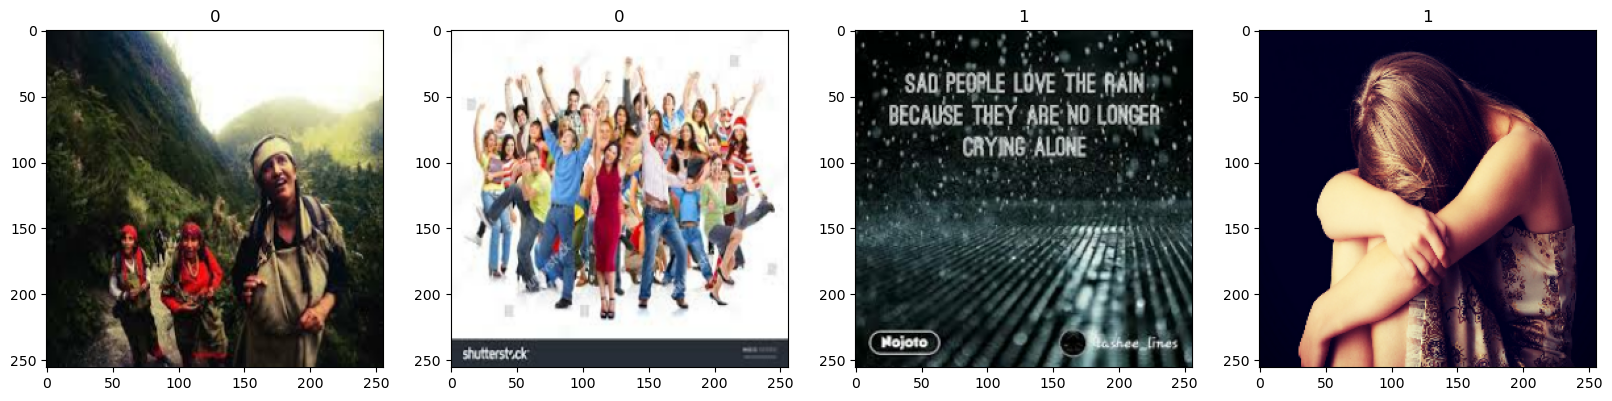

In [15]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [16]:
# to get another batch from the iterator, run [[batch = data_iterator.next()]]

## Preprocess the data

### Scale the data

In [17]:
# We do this to optimize faster

In [18]:
scaled = batch[0]/255

In [19]:
scaled.max()

1.0

In [20]:
# tranformation will be done in pipeline, instead of doing this for every batch created by data_iterator
data = data.map(lambda x, y: (x/255,y))

In [21]:
scaled_iterator = data.as_numpy_iterator()

In [22]:
batch = scaled_iterator.next()
batch[0]

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [23]:
batch[0].max()

1.0

### Split the data

In [24]:
len(data)

12

In [25]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [26]:
train_size + val_size + test_size

12

In [27]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

## Build Deep Learning Model!!

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [34]:
#30*30*16

14400

### Train

In [35]:
logdir = 'logs'

In [36]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [38]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


8/8 [==============================] - 7s 647ms/step - loss: 0.5968 - accuracy: 0.6641 - val_loss: 0.4188 - val_accuracy: 0.8125
Epoch 2/20
8/8 [==============================] - 5s 545ms/step - loss: 0.5086 - accuracy: 0.7227 - val_loss: 0.6325 - val_accuracy: 0.6719
Epoch 3/20
8/8 [==============================] - 5s 548ms/step - loss: 0.5159 - accuracy: 0.7578 - val_loss: 0.4491 - val_accuracy: 0.7656
Epoch 4/20
8/8 [==============================] - 6s 623ms/step - loss: 0.4458 - accuracy: 0.7930 - val_loss: 0.4087 - val_accuracy: 0.8281
Epoch 5/20
8/8 [==============================] - 5s 565ms/step - loss: 0.3462 - accuracy: 0.8516 - val_loss: 0.3165 - val_accuracy: 0.8438
Epoch 6/20
8/8 [==============================] - 5s 581ms/step - loss: 0.3012 - accuracy: 0.8945 - val_loss: 0.2018 - val_accuracy: 0.9375
Epoch 7/20
8/8 [==============================] - 6s 656ms/step - loss: 0.2561 - accuracy: 0.8984 - val_loss: 0.2358 - val_accuracy: 0.9531
Epoch 8/20
8/8 [==

### Plot Performance

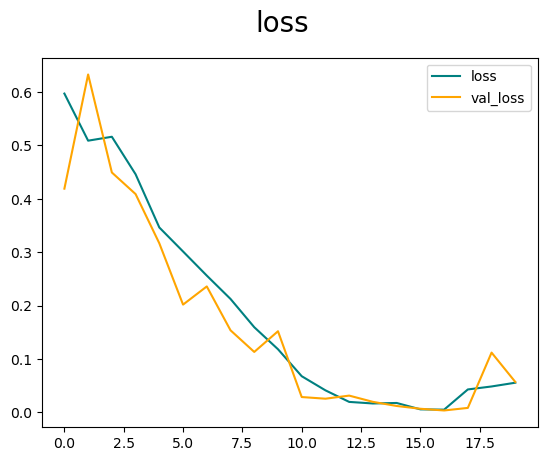

In [40]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

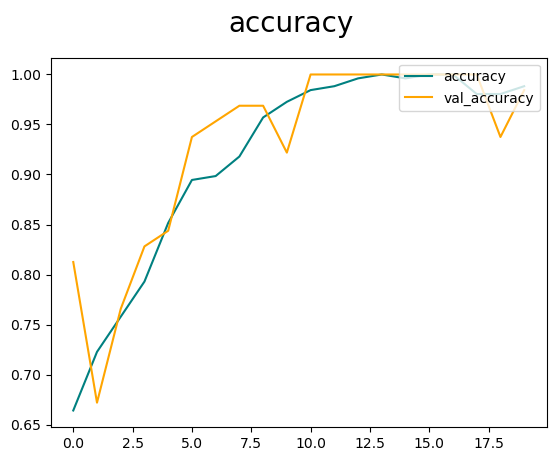

In [41]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper right')
plt.show()

## Evaluate Performance

In [44]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [45]:
for batch in test.as_numpy_iterator():
    X, y =batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 139ms/step


In [46]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:0.7777777910232544, Accuracy:0.9622641801834106


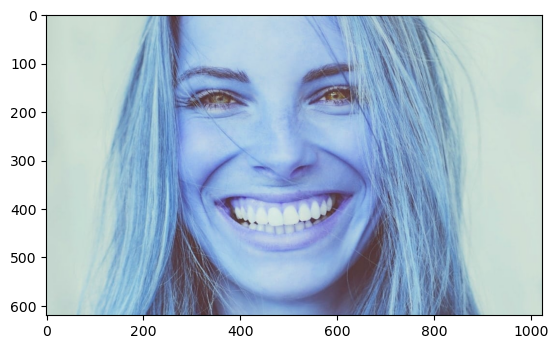

In [60]:
img = cv2.imread('happytest.jpg')
plt.imshow(img)
plt.show()

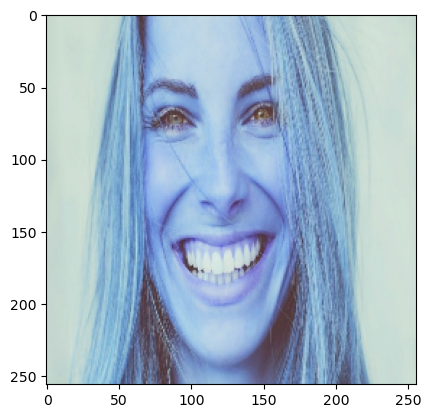

In [61]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [62]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 31ms/step


In [63]:
yhat

array([[0.11394111]], dtype=float32)

## Save the Model

### Save model

In [64]:
model.save(os.path.join('models','happysadclassifiermodel.h5'))

In [65]:
new_model = load_model(os.path.join('models','happysadclassifiermodel.h5'))

In [66]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 83ms/step


In [67]:
if yhatnew < 0.5:
    print('Predicted Class is Happy!!')
else:
    print('Predicted Class is Sad')

Predicted Class is Happy!!
